In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline as ImbPipeline 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

### 1. Exploratory data analysis

In [143]:
#Loading data
df=pd.read_csv('../data/Fraud_Data.csv')

In [144]:
df.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,149671,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0
1,15611,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0
2,73178,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0
3,84546,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0
4,35978,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0


In [4]:
# Initial statittics on raw data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      120000 non-null  int64  
 1   user_id         120000 non-null  int64  
 2   signup_time     120000 non-null  object 
 3   purchase_time   120000 non-null  object 
 4   purchase_value  120000 non-null  int64  
 5   device_id       120000 non-null  object 
 6   source          120000 non-null  object 
 7   browser         120000 non-null  object 
 8   sex             120000 non-null  object 
 9   age             120000 non-null  int64  
 10  ip_address      120000 non-null  float64
 11  class           120000 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 11.0+ MB


In [122]:
print(f'There are {df.shape[0]} data points  and {df.shape[1]} columns')

There are 120000 data points  and 23 columns


#### 1.1. Initial data insights:
- There are no missing data in the original data.
- There are :
    - numerical (age, purchase_value)
    - categorical (source, browser, sex, device_id) 
    - timestamp (signup_time, purchase_time -  there will be further transformed into numerical) features.
- ip_address is of numerical type but it is actually categorical as it will be further used to extract country of transaction 

### 1.2 Data and features distributions

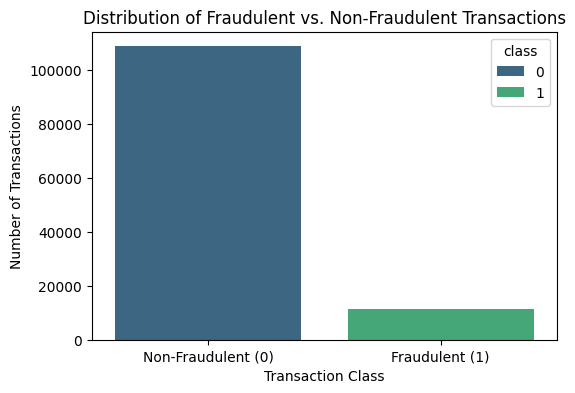

In [7]:
class_counts = df['class'].value_counts()

# Plotting class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis",hue=class_counts.index)
plt.xlabel("Transaction Class")
plt.ylabel("Number of Transactions")
plt.title("Distribution of Fraudulent vs. Non-Fraudulent Transactions")
plt.xticks([0, 1], ['Non-Fraudulent (0)', 'Fraudulent (1)'])
plt.show()

The dataset is significantly imballanced with vast domination (~ 10 times) of non-fraudulent transactions against the fradulent ones  

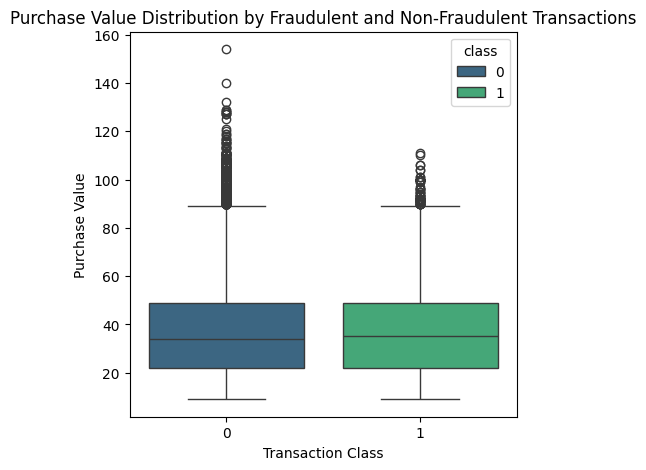

In [26]:
# Visualizing relationship between purchase value and fraud class
plt.figure(figsize=(5, 5))
sns.boxplot(x='class', y='purchase_value', data=df, palette="viridis", hue='class')
plt.xlabel("Transaction Class")
plt.ylabel("Purchase Value")
plt.title("Purchase Value Distribution by Fraudulent and Non-Fraudulent Transactions")
plt.show()

The distributions of transaction prices of fraudulent and non-fradulent transactions look very similar with no pronounced fradulent patterns (e.g., skewness towards larege purchase values)

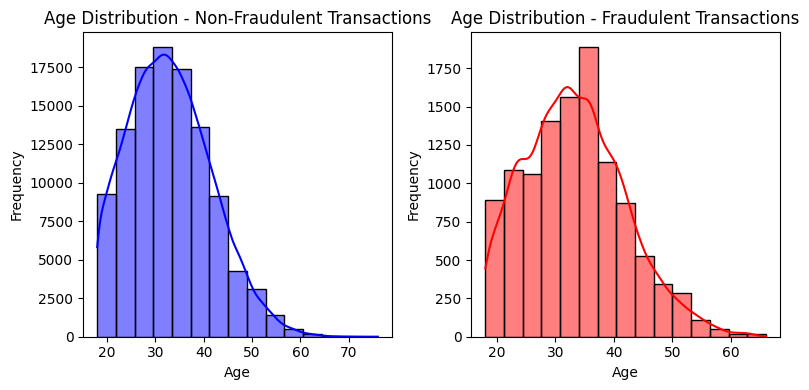

In [29]:
plt.figure(figsize=(8, 4))

# Non-fraudulent transactions
plt.subplot(1, 2, 1)
sns.histplot(data=df[df['class'] == 0], x='age', color="blue", kde=True, bins=15)
plt.title("Age Distribution - Non-Fraudulent Transactions")
plt.xlabel("Age")
plt.ylabel("Frequency")

# Fraudulent transactions
plt.subplot(1, 2, 2)
sns.histplot(data=df[df['class'] == 1], x='age', color="red", kde=True, bins=15)
plt.title("Age Distribution - Fraudulent Transactions")
plt.xlabel("Age")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

The age distributions of fraudulent and non-fradulent transactions look also rather similar

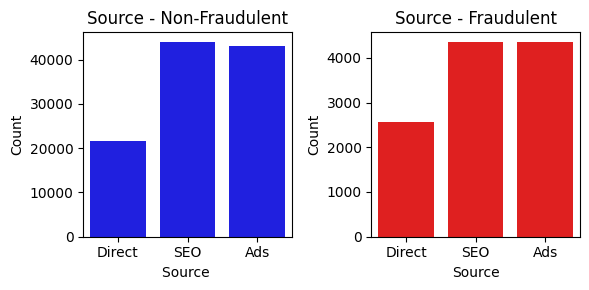

In [123]:
plt.figure(figsize=(6, 3))
# Non-fraudulent transactions
plt.subplot(1, 2, 1)
sns.countplot(data=df[df['class'] == 0], x='source', color="blue")
plt.title("Source - Non-Fraudulent")
plt.xlabel("Source ")
plt.ylabel("Count")
# Fraudulent transactions
plt.subplot(1, 2, 2)
sns.countplot(data=df[df['class'] == 1], x='source', color="red")
plt.title("Source - Fraudulent")
plt.xlabel("Source")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

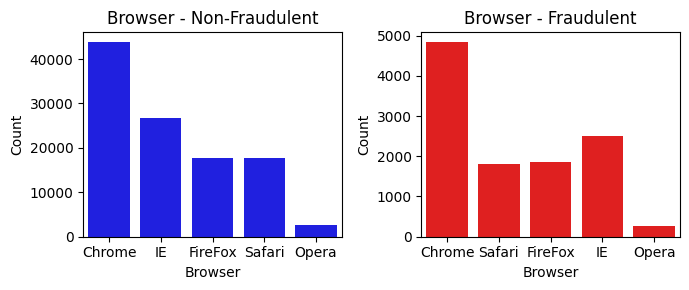

In [124]:
plt.figure(figsize=(7, 3))
# Non-fraudulent transactions
plt.subplot(1, 2, 1)
sns.countplot(data=df[df['class'] == 0], x='browser', color="blue")
plt.title("Browser - Non-Fraudulent")
plt.xlabel("Browser")
plt.ylabel("Count")
# Fraudulent transactions
plt.subplot(1, 2, 2)
sns.countplot(data=df[df['class'] == 1], x='browser', color="red")
plt.title("Browser - Fraudulent")
plt.xlabel("Browser")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

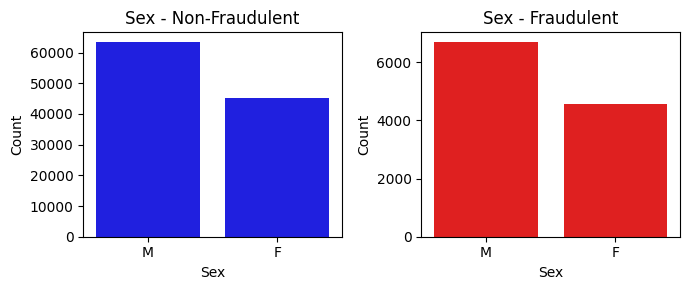

In [125]:
plt.figure(figsize=(7, 3))
# Non-fraudulent transactions
plt.subplot(1, 2, 1)
sns.countplot(data=df[df['class'] == 0], x='sex', color="blue")
plt.title("Sex - Non-Fraudulent")
plt.xlabel("Sex")
plt.ylabel("Count")
# Fraudulent transactions
plt.subplot(1, 2, 2)
sns.countplot(data=df[df['class'] == 1], x='sex', color="red")
plt.title("Sex - Fraudulent")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

'Source', 'Browser', 'Sex' features also do not exhibit any characteristic patterns between frauds and non-frauds

### Transactions from the same device_id

In [148]:
##Checking transactions executed from the same device ID
df['device_id'].value_counts()[:5]

device_id
ITUMJCKWEYNDD    19
KIPFSCNUGOLDP    17
EQYVNEGOFLAWK    17
ZUSVMDEZRBDTX    17
UFBULQADXSSOG    16
Name: count, dtype: int64

In [149]:
df[df['device_id']=='KIPFSCNUGOLDP']

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
785,111645,74754,1/3/2015 10:47,1/3/2015 10:47,58,KIPFSCNUGOLDP,SEO,Safari,F,36,576060872.5,1
7777,8452,274333,1/3/2015 10:47,1/3/2015 10:47,58,KIPFSCNUGOLDP,SEO,Safari,F,36,576060872.5,1
17258,3243,340765,1/3/2015 10:47,1/3/2015 10:47,58,KIPFSCNUGOLDP,SEO,Safari,F,36,576060872.5,1
17771,106051,62239,1/3/2015 10:47,1/3/2015 10:47,58,KIPFSCNUGOLDP,SEO,Safari,F,36,576060872.5,1
18223,75009,124779,1/3/2015 10:47,1/3/2015 10:47,58,KIPFSCNUGOLDP,SEO,Safari,F,36,576060872.5,1
20770,129718,306702,1/3/2015 10:47,1/3/2015 10:47,58,KIPFSCNUGOLDP,SEO,Safari,F,36,576060872.5,1
41263,38362,167569,1/3/2015 10:47,1/3/2015 10:47,58,KIPFSCNUGOLDP,SEO,Safari,F,36,576060872.5,1
53431,63637,34111,1/3/2015 10:47,1/3/2015 10:47,58,KIPFSCNUGOLDP,SEO,Safari,F,36,576060872.5,1
53566,112823,866,1/3/2015 10:47,1/3/2015 10:47,58,KIPFSCNUGOLDP,SEO,Safari,F,36,576060872.5,1
61896,112252,123600,1/3/2015 10:47,1/3/2015 10:47,58,KIPFSCNUGOLDP,SEO,Safari,F,36,576060872.5,1


Device_id used in several transactions strongly indicate that transactions are fraudulent

### 1.3 Mapping ip_addresses to respective countries

In [3]:
ip_country_data = pd.read_excel('../data/IpAddress_to_Country.xlsx')

In [4]:
# Define a function to map IP address to country based on IP range
def map_ip_to_country(ip):
    country_row = ip_country_data[(ip_country_data['lower_bound_ip_address'] <= ip) & (ip_country_data['upper_bound_ip_address'] >= ip)]
    if not country_row.empty:
        return country_row['country'].values[0]
    else:
        return None

In [5]:
df['country'] = df['ip_address'].apply(map_ip_to_country)

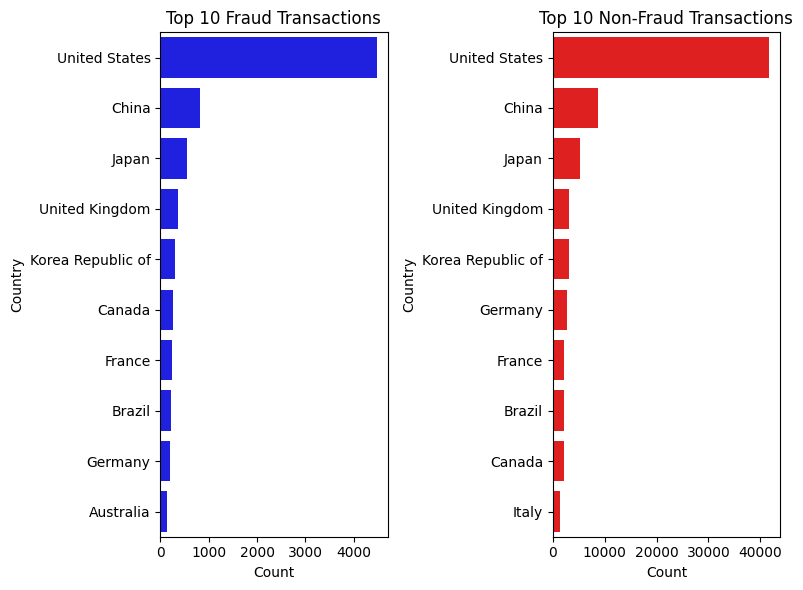

In [56]:
# Top countries for fraudulent and non-fraudulent transactions
top_countries_fraud = df[df['class'] == 1]['country'].value_counts().head(10)
top_countries_non_fraud = df[df['class'] == 0]['country'].value_counts().head(10)
# Plotting top countries by fraud and non-fraud transactions
plt.figure(figsize=(8, 6))
# Fraudulent transactions by country
plt.subplot(1, 2, 1)
sns.barplot(y=top_countries_fraud.index, x=top_countries_fraud.values, color="blue")
plt.title("Top 10 Fraud Transactions")
plt.xlabel("Count")
plt.ylabel("Country")
# Non-fraudulent transactions by country
plt.subplot(1, 2, 2)
sns.barplot(y=top_countries_non_fraud.index, x=top_countries_non_fraud.values, color="red")
plt.title("Top 10 Non-Fraud Transactions")
plt.xlabel("Count")
plt.ylabel("Country")

plt.tight_layout()
plt.show()

Top 5 countries by transaction volume with Fradulent transactions are the same as for Non-Fradulent

### 1.4 Difference between Signup time and purchase time

One hypothesis to detect the anomolous patterns is to check the difference between sign up and purchase times.\
The intuition behind: those who plan a fraud would signup and quickly execute this transaction.

In [6]:
# Converting to datetime format
df['signup_time']=pd.to_datetime(df['signup_time']).dt.tz_localize('UTC')
df['purchase_time']=pd.to_datetime(df['purchase_time']).dt.tz_localize('UTC')
#Time difference between signing up and purchase
df['time_diff_hours'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds() / 3600

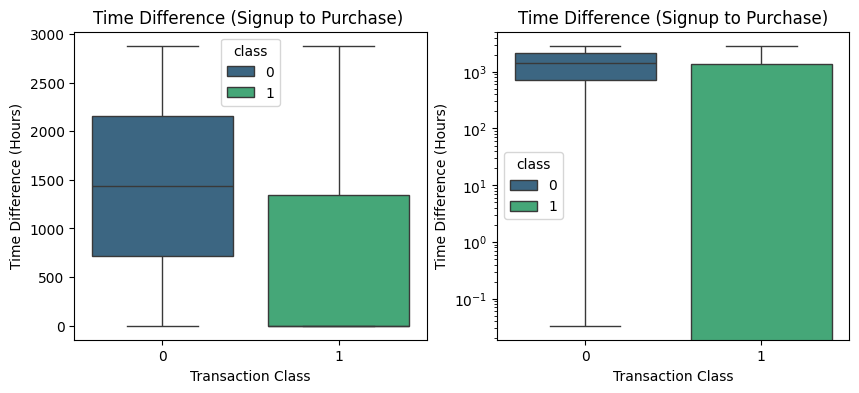

In [67]:
# Visualizing relationship between time difference (signup and purchase) and fraud class

plt.figure(figsize=(10, 4))

# Non-fraudulent transactions
plt.subplot(1, 2, 1)
sns.boxplot(x='class', y='time_diff_hours', data=df, palette="viridis", hue='class')
plt.xlabel("Transaction Class")
plt.ylabel("Time Difference (Hours)")
plt.title("Time Difference (Signup to Purchase) ")

plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='time_diff_hours', data=df, palette="viridis", hue='class')
plt.xlabel("Transaction Class")
plt.ylabel("Time Difference (Hours)")
plt.title("Time Difference (Signup to Purchase)")
plt.yscale('log')  # Log scale to handle large differences
plt.show()

- Clear pattern is deteced for fraud transactions
- For about half of fraud transactions the difference between sign up and purhase times are either exacty 0 or very small
- This patter is absent in non-fraud transactions
- sign up - purhase time difference is a good canditate for a feature with high predictive power


### 1.5 Converting GMT-timezone time format to local time of respective coutries

In [126]:
#Loading dictionary mapping between countries and respective timezones
with open("country_to_timezone.json", "r") as json_file:
    country_to_timezone = json.load(json_file)

In [8]:
#Converting purchase_time from GMT to local timezone
def convert_to_local_time(row):
    country = row['country']
    if pd.notnull(country) and country in country_to_timezone:
        return row['purchase_time'].tz_convert(country_to_timezone[country]).tz_localize(None)
    else:
        return row['purchase_time']  

In [9]:
df['local_purchase_time'] = df.apply(convert_to_local_time, axis=1)

In [10]:
#Converting signup_time from GMT to local timezone
def convert_to_local_signup_time(row):
    country = row['country']
    if pd.notnull(country) and country in country_to_timezone:
        return row['signup_time'].tz_convert(country_to_timezone[country]).tz_localize(None)
    else:
        return row['signup_time'] 

In [11]:
df['local_signup_time']=df.apply(convert_to_local_signup_time, axis=1)

In [12]:
df['local_purchase_time']=pd.to_datetime(df['local_purchase_time'], utc=True)
df['local_signup_time']=pd.to_datetime(df['local_signup_time'], utc=True)

In [13]:
#Extracting hour and day of week values from timestamps
df['signup_hour'] = df['signup_time'].dt.hour
df['local_signup_hour'] = df['local_signup_time'].dt.hour
df['purchase_hour'] = df['purchase_time'].dt.hour
df['local_purchase_hour'] = df['local_purchase_time'].dt.hour
df['signup_dayofweek'] = df['signup_time'].dt.dayofweek
df['purchase_dayofweek'] = df['purchase_time'].dt.dayofweek

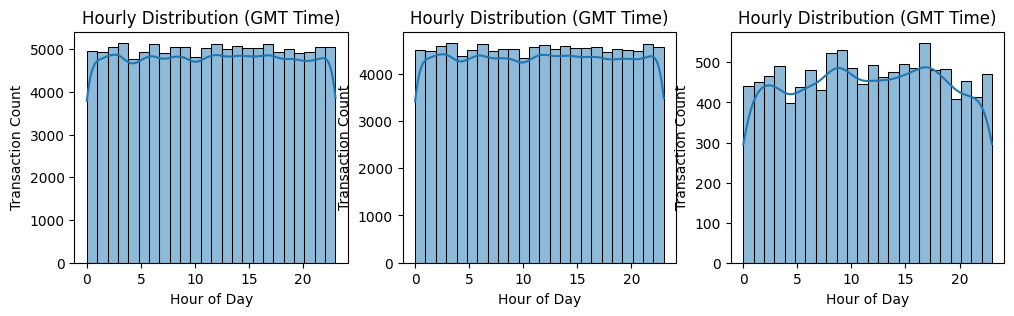

In [85]:
#  Hourly Distribution of Transactions GMT time
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
sns.histplot(df['purchase_hour'], bins=24, kde=True)
plt.title("Hourly Distribution (GMT Time)")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.subplot(1, 3, 2)
sns.histplot(df[df['class']==0]['purchase_hour'], bins=24, kde=True)
plt.title("Hourly Distribution (GMT Time)")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.subplot(1, 3, 3)
sns.histplot(df[df['class']==1]['purchase_hour'], bins=24, kde=True)
plt.title("Hourly Distribution (GMT Time)")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.show()

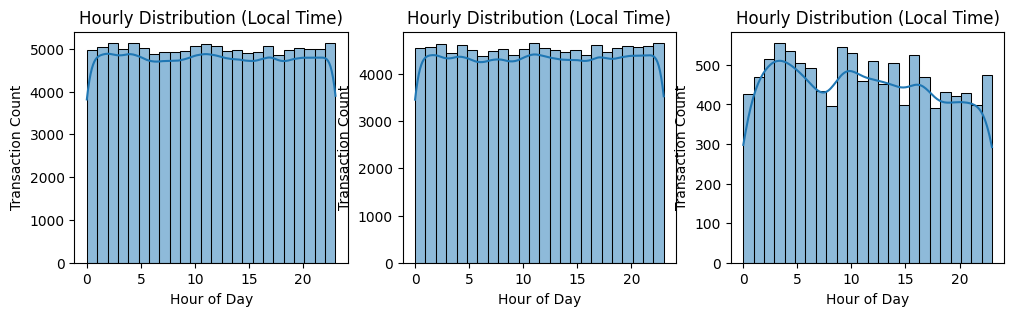

In [86]:
#  Hourly Distribution of Transactions Local time
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
sns.histplot(df['local_purchase_hour'], bins=24, kde=True)
plt.title("Hourly Distribution (Local Time)")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.subplot(1, 3, 2)
sns.histplot(df[df['class']==0]['local_purchase_hour'], bins=24, kde=True)
plt.title("Hourly Distribution (Local Time)")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.subplot(1, 3, 3)
sns.histplot(df[df['class']==1]['local_purchase_hour'], bins=24, kde=True)
plt.title("Hourly Distribution (Local Time)")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.show()

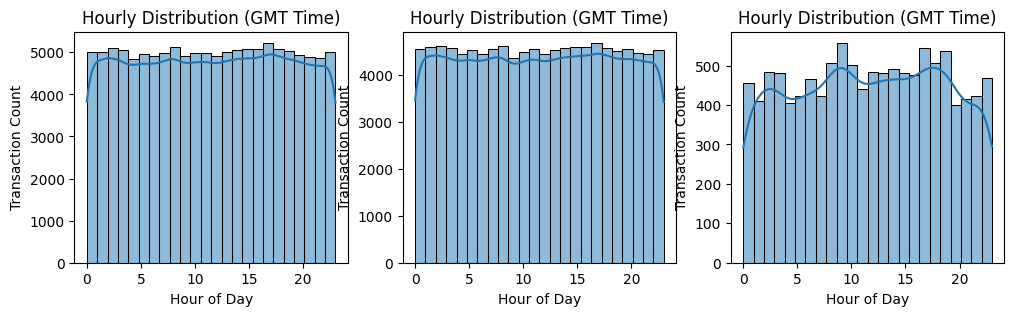

In [88]:
#  Hourly Distribution of Sign Up GMT time
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
sns.histplot(df['signup_hour'], bins=24, kde=True)
plt.title("Hourly Distribution (GMT Time)")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.subplot(1, 3, 2)
sns.histplot(df[df['class']==0]['signup_hour'], bins=24, kde=True)
plt.title("Hourly Distribution (GMT Time)")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.subplot(1, 3, 3)
sns.histplot(df[df['class']==1]['signup_hour'], bins=24, kde=True)
plt.title("Hourly Distribution (GMT Time)")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.show()

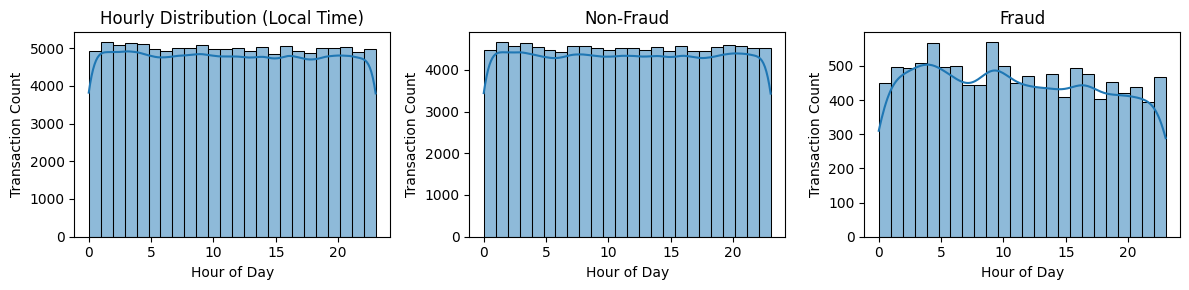

In [106]:
#  Hourly Distribution of Sign up Local time
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
sns.histplot(df['local_signup_hour'], bins=24, kde=True)
plt.title("Hourly Distribution (Local Time)")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.subplot(1, 3, 2)
sns.histplot(df[df['class']==0]['local_signup_hour'], bins=24, kde=True)
plt.title("Non-Fraud")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.subplot(1, 3, 3)
sns.histplot(df[df['class']==1]['local_signup_hour'], bins=24, kde=True)
plt.title("Fraud")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.tight_layout()
plt.show()

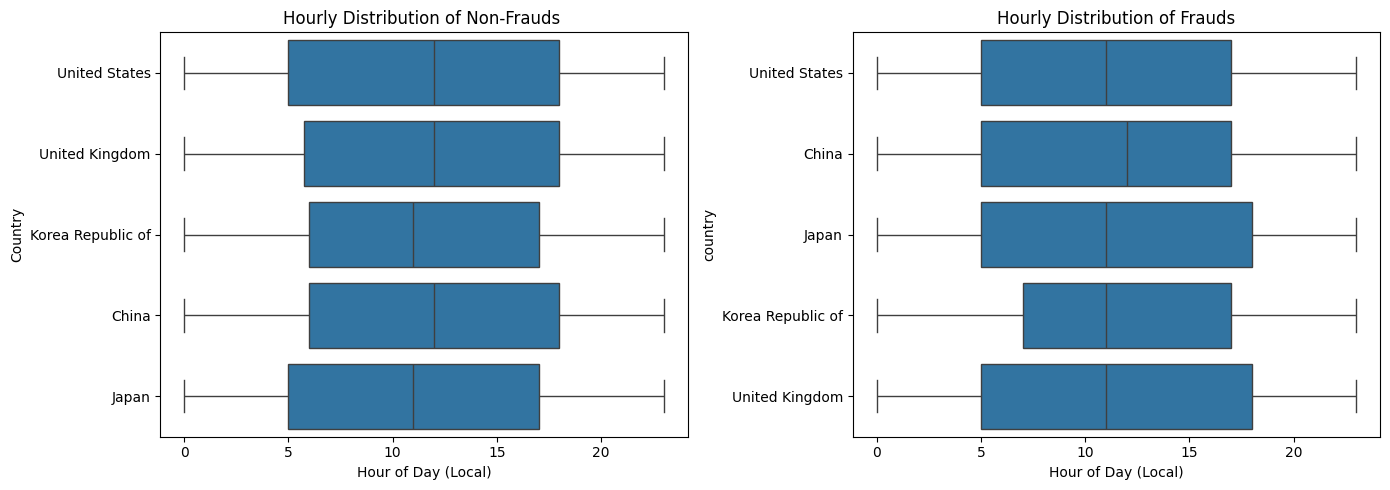

In [105]:
# Hourly Distribution by Country (focus on top 5 countries by transaction volume)
top_countries_not_fraud = df[df['class']==0]['country'].value_counts().index[:5]
top_countries_frauds = df[df['class']==1]['country'].value_counts().index[:5]
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='local_purchase_hour', y='country', data=df[df['class']==0][df[df['class']==0]['country'].isin(top_countries_not_fraud)], orient="h")
plt.title("Hourly Distribution of Non-Frauds ")
plt.xlabel("Hour of Day (Local)")
plt.ylabel("Country")

plt.subplot(1, 2, 2)
sns.boxplot(x='local_purchase_hour', y='country', data=df[df['class']==1][df[df['class']==1]['country'].isin(top_countries_frauds)], orient="h")
plt.title("Hourly Distribution of Frauds")
plt.xlabel("Hour of Day (Local)")
#plt.ylabel("Country")

plt.tight_layout()
plt.show()

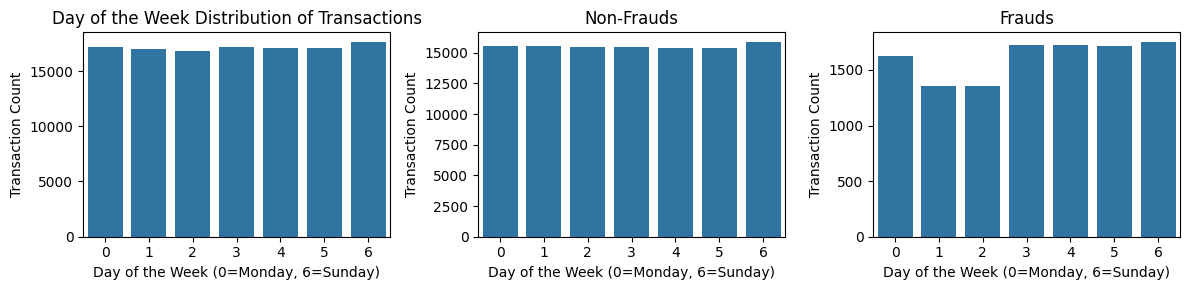

In [110]:
#  Daily Distribution of purchases
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
sns.countplot(x='purchase_dayofweek', data=df, order=[0, 1, 2, 3, 4, 5, 6])
plt.title("Day of the Week Distribution of Transactions")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Transaction Count")
plt.subplot(1, 3, 2)
sns.countplot(x='purchase_dayofweek', data=df[df['class']==0], order=[0, 1, 2, 3, 4, 5, 6])
plt.title("Non-Frauds")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Transaction Count")
plt.subplot(1, 3, 3)
sns.countplot(x='purchase_dayofweek', data=df[df['class']==1], order=[0, 1, 2, 3, 4, 5, 6])
plt.title("Frauds")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Transaction Count")
plt.tight_layout()
plt.show()

No clear pattern is seen distinguishing frauds from non-frauds in the graphs above (GMT, local timezone, day of week)

### 2. Feature Engineering

Some of feature has already been engineered above, which are:
- 'time_diff_hours' time difference in hours between sign up and purchase
- 'signup_hour'
- 'local_signup_hour'
- 'purchase_hour'
- 'local_purchase_hour'
- 'signup_dayofweek'
- 'purchase_dayofweek'

Encoding 'country' variable as fraud transaction rate for this country weighted to the total number of transactions for this country

In [14]:
country_fraud_rate = df.groupby('country')['class'].mean()
#  Calculate the transaction proportion (weight) for each country
country_total_transactions = df['country'].value_counts()
country_transaction_weight = country_total_transactions / len(df)
#  Compute the weighted fraud rate by multiplying the fraud rate by the transaction weight
country_weighted_fraud_rate = country_fraud_rate * country_transaction_weight
median_weighted_fraud_rate = country_weighted_fraud_rate.median()

In [15]:
df['country_w_fraud_rate'] = df['country'].map(country_weighted_fraud_rate)

In [16]:
df['country_w_fraud_rate']=df['country_w_fraud_rate'].fillna(median_weighted_fraud_rate)

In [17]:
df2=df.copy(deep=True)

In [18]:
#Encoding gender feature
df2['sex_encoded'] = df2['sex'].map({'M': 0, 'F': 1})
#Handling categorical features: 'source', 'browser', 
# use one-hot encoding for categorical features
df2 = pd.get_dummies(df2, columns=['source', 'browser'], drop_first=True ,dtype='int')

In [20]:
df2 = df2.drop(['Unnamed: 0', 'user_id', 'device_id', 'signup_time', 'local_signup_time', 'purchase_time','local_purchase_time', 'ip_address','country',  'sex'], axis=1)

In [22]:
df.to_csv('../data/data4modeling.csv', index=False)

### 3. Modelling

In [23]:
# Split features and target
X = df2.drop(columns=['class'])
y = df2['class']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

To account for the special evaluation function for False Negative (price of transaction) and False Positive (inconvenience for customer)

In [27]:
## Evaluation function
def evaluation(model, xtest, ytest):
  y_pred = model.predict(xtest)

  # Evaluate model using standard metrics
  print("Classification Report:")
  print(classification_report(ytest, y_pred))
  print("\nConfusion Matrix:")
  print(confusion_matrix(ytest, y_pred))

  # Custom Cost-Based Evaluation
  conf_matrix = confusion_matrix(ytest, y_pred)
  tn, fp, fn, tp = conf_matrix.ravel()

  # Calculate the cost based on false positives and false negatives
  false_negatives = xtest[(ytest == 1) & (y_pred == 0)]
  cost_fn = false_negatives['purchase_value'].sum()  # Sum the cost of missed frauds
  cost_fp = fp * 8  # Each false positive incurs an $8 inconvenience cost

  # Total cost of misclassification
  total_cost = cost_fn + cost_fp

  print("\nCustom Cost-Based Evaluation Metric")
  print(f"Total cost of false negatives (missed frauds): ${cost_fn}")
  print(f"Total cost of false positives (customer inconvenience): ${cost_fp}")
  print(f"Overall misclassification cost: ${total_cost}")
  return None

#### 3.1 Linear model - Logistic Regression with L1 penalty

In [127]:
# Create a pipeline with SMOTE for oversampling and Lasso (Logistic Regression with L1 penalty)
pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),                # Scale features
    ('smote', SMOTE(sampling_strategy=1.0, random_state=42)),     # Balance classes by oversampling the minority class
    ('lasso', LogisticRegression(penalty='l1', solver='saga', class_weight='balanced', C=1, max_iter=1000))  # Lasso (L1)
])

In [128]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTE(random_state=42, sampling_strategy=1.0)),
                ('lasso',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    penalty='l1', solver='saga'))])

In [129]:
evaluation(pipeline, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.65      0.77     21747
           1       0.17      0.69      0.27      2253

    accuracy                           0.65     24000
   macro avg       0.56      0.67      0.52     24000
weighted avg       0.88      0.65      0.73     24000


Confusion Matrix:
[[14141  7606]
 [  688  1565]]

Custom Cost-Based Evaluation Metric
Total cost of false negatives (missed frauds): $25472
Total cost of false positives (customer inconvenience): $60848
Overall misclassification cost: $86320


In [130]:
lasso_model = pipeline.named_steps['lasso']  # Access the fitted Logistic Regression model

# Extract feature names and their coefficients
feature_names = X_train.columns
coefficients = lasso_model.coef_[0]  # Get the coefficients for the model

# Create a DataFrame to hold the feature names and their corresponding coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
})

# Sort features by absolute importance
feature_importance['Absolute Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Importance', ascending=False)

# Display the sorted feature importance
print(feature_importance[['Feature', 'Importance']])

                 Feature  Importance
2        time_diff_hours   -0.862080
11         source_Direct    0.070075
8     purchase_dayofweek    0.047025
14            browser_IE   -0.041348
9   country_w_fraud_rate    0.033041
6    local_purchase_hour   -0.030472
10           sex_encoded   -0.027238
12            source_SEO   -0.022408
7       signup_dayofweek    0.021776
4      local_signup_hour   -0.021694
15         browser_Opera   -0.017446
3            signup_hour    0.011001
13       browser_FireFox   -0.008897
1                    age   -0.007102
16        browser_Safari    0.004686
0         purchase_value    0.002958
5          purchase_hour   -0.002840


'time_diff_hours' feature appears to be largely dominant 

#### 3.2 Support Vector Classifier

In [24]:
# Create a pipeline with oversampling, scaling, and SVC
pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),                # Scale features
    ('undersample', RandomUnderSampler(sampling_strategy=1.0, random_state=42)),  # Undersample the majority class
    ('svc', SVC(class_weight='balanced', C=1, kernel='rbf', random_state=42))   # SVM with balanced class weights
])

In [25]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('undersample',
                 RandomUnderSampler(random_state=42, sampling_strategy=1.0)),
                ('svc', SVC(C=1, class_weight='balanced', random_state=42))])

In [28]:
evaluation(pipeline, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     21747
           1       0.47      0.58      0.52      2253

    accuracy                           0.90     24000
   macro avg       0.71      0.75      0.73     24000
weighted avg       0.91      0.90      0.90     24000


Confusion Matrix:
[[20287  1460]
 [  954  1299]]

Custom Cost-Based Evaluation Metric
Total cost of false negatives (missed frauds): $34752
Total cost of false positives (customer inconvenience): $11680
Overall misclassification cost: $46432


#### 3.3 Gradient boosting - XGB classifier

In [118]:
xgb_clf = XGBClassifier(
    # objective="binary:logistic",
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    # scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42,
)

In [119]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [120]:
evaluation(xgb_clf, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     21747
           1       0.98      0.54      0.70      2253

    accuracy                           0.96     24000
   macro avg       0.97      0.77      0.84     24000
weighted avg       0.96      0.96      0.95     24000


Confusion Matrix:
[[21728    19]
 [ 1026  1227]]

Custom Cost-Based Evaluation Metric
Total cost of false negatives (missed frauds): $37286
Total cost of false positives (customer inconvenience): $152
Overall misclassification cost: $37438


In [121]:
feature_importance = xgb_clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                 Feature  Importance
2        time_diff_hours    0.695891
4      local_signup_hour    0.043406
6    local_purchase_hour    0.026159
5          purchase_hour    0.023740
11         source_Direct    0.021828
3            signup_hour    0.021180
7       signup_dayofweek    0.020035
12            source_SEO    0.015977
10           sex_encoded    0.015755
13       browser_FireFox    0.015231
9   country_w_fraud_rate    0.015035
14            browser_IE    0.014864
15         browser_Opera    0.014735
16        browser_Safari    0.014543
8     purchase_dayofweek    0.014140
1                    age    0.014067
0         purchase_value    0.013413


#### 3.4 Ensembling Logistic Regression with L1 penalty and XGB classifier

In [85]:
# Define pipelines for models
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('lasso', LogisticRegression(penalty='l1', solver='saga', C=1, class_weight='balanced', random_state=42))
])

xgb_clf = XGBClassifier(objective="binary:logistic",
                        n_estimators=100,
                        learning_rate=0.1,
                        max_depth=5,
                        random_state=42)

# Meta-classifier
meta_clf = LogisticRegression(random_state=42, class_weight='balanced')

# Define StackingClassifier
stacking_clf = StackingClassifier(
    estimators=[
        ('lasso', lasso_pipeline),  # Use pipeline with scaling for Lasso
        ('xgb', xgb_clf)
    ],
    final_estimator=meta_clf,  # Meta-classifier
    cv=3  # Cross-validation for base model predictions
)

In [86]:
# Fit the stacking ensemble
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=3,
                   estimators=[('lasso',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('lasso',
                                                 LogisticRegression(C=1,
                                                                    class_weight='balanced',
                                                                    penalty='l1',
                                                                    random_state=42,
                                                                    solver='saga'))])),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stoppin...
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=9,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      random_state=42))

In [87]:
evaluation(stacking_clf, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21747
           1       0.95      0.55      0.69      2253

    accuracy                           0.95     24000
   macro avg       0.95      0.77      0.84     24000
weighted avg       0.95      0.95      0.95     24000


Confusion Matrix:
[[21686    61]
 [ 1021  1232]]

Custom Cost-Based Evaluation Metric
Total cost of false negatives (missed frauds): $37097
Total cost of false positives (customer inconvenience): $488
Overall misclassification cost: $37585


### 4. Conclusion and next steps

Modeling:
- Subsequent increase of models complexity (linear -> Support Vector Classifier -> XGB classifier) resulted in improved overal performance \
 considering the custom evaluation function (with penalties for False Negative and False Positives)
 - However, even for the best performing models (XGB classifier and Ensembling) the number of false negative is quite high
 - From feature importance analysis the most dominant one is the difference between sign up and purchase times

 Feature engineering:
 - I put aside and did not use 'device_id' feature even though from the first glance one can encode it as fraud frequency rate
 - In my opinion it would lead to significant data leakage as the it seems like that the decive_id with a lot of frauds were marked as fraudulent \
 by some external means (reporting the first transaction as fraudulent and then marking this device_id fraudulent as well)

 Next steps:
 - With this data the modeling seems to be quite limited as apart from 'time_diff_hours' the other features appear to be quite weak predictors
 - I would consider adding rule-based business logic by making, for example, black lists of fradulent device ids (but this is out of scope of machine learning modeling)